In [1]:
import torch
import numpy as np
import os 
import inspect
import sys
import time
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
parentdir = os.path.dirname(parentdir)
sys.path.insert(0, parentdir) 

from utils import set_seed, query_environment_info, read_config_from_yaml
from model import  Quad_Value_Net, Policy,WaveFunction_Koopman_dynamics
from solver import create_solver
from roll_out import roll_out
from dataset import RLDataset
import controlgym as gym
from controlgym.helpers.plotting import _plot_coupled_pde
import matplotlib.pyplot as plt


torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True
set_seed(2024)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = read_config_from_yaml("training_scripts/wave/config.yaml")

[INFO] Setting the seed to 2024
[INFO] Loaded data from training_scripts/wave/config.yaml


In [2]:
# Create environment
env_name = config["env_name"]
process_noise_cov = config["process_noise_cov"]
sensor_noise_cov = config["sensor_noise_cov"]
n_state = config["n_state"]
n_obs = config["n_observation"]
n_action = config["n_action"]
observation_limit = config["observation_limit"]
action_limit = config["action_limit"]
R_weight = config["R_weight"]
Q_weight = config["Q_weight"]
env = gym.make(env_name, process_noise_cov=process_noise_cov, 
                         sensor_noise_cov=sensor_noise_cov,
                         n_state=n_state, n_observation=n_obs, n_action=n_action,
                         action_limit=action_limit, 
                         observation_limit=observation_limit,
                         R_weight=R_weight, 
                         Q_weight=Q_weight)
env.n_steps = config["eval_T"]
env_info = query_environment_info(env, env_name)
state_dim = env.observation_space.shape[0] 
act_dim = env.action_space.shape[0]

[INFO] Creating the environment: <WaveEnv instance>
Name: wave
Action Space: Box(-1.0, 1.0, (10,), float64)
Observation Space: Box(-10.0, 10.0, (50,), float64)
Reward Range: (-1000000000000000.0, 1000000000000000.0)



In [3]:
# Construct and Load Model
save_path = "trained_weights"
num_steps = config["num_steps"]
hidden_dim = config["hidden_dim"]

pos_dim = int(state_dim/2)
velocity_dim = int(state_dim/2)

Kdys_model = WaveFunction_Koopman_dynamics(pos_dim=pos_dim, velocity_dim=velocity_dim,hidden_dim=hidden_dim, act_dim=act_dim, num_steps=num_steps).to(device)
Kdys_model.load_state_dict(torch.load(save_path + '/KoopmanDynamics.pt', map_location=torch.device('cpu')))
Kz = torch.load(save_path + '/Kz.pt', map_location=torch.device('cpu'))
Jz_B = torch.load(save_path + '/Jz_B.pt', map_location=torch.device('cpu'))
Kdys_model.koopman.Kz = Kz.to(device)
Kdys_model.koopman.Jz_B = Jz_B.to(device)
Kdys_model.to(device)

WaveFunction_Koopman_dynamics(
  (koopman): KoopmanOp()
  (encoder): WaveFunctionEncoder(
    (position_enocder): Sequential(
      (0): Linear(in_features=25, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): Tanh()
      (4): Linear(in_features=32, out_features=32, bias=True)
      (5): Tanh()
    )
    (velocity_encoder): Sequential(
      (0): Linear(in_features=25, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): Tanh()
      (4): Linear(in_features=32, out_features=32, bias=True)
      (5): Tanh()
    )
    (joint_encoder): Linear(in_features=64, out_features=64, bias=True)
  )
  (decoder): WaveFunctionDecoder(
    (joint_decoder): Linear(in_features=64, out_features=64, bias=True)
    (position_decoder): Sequential(
      (0): Tanh()
      (1): Linear(in_features=32, out_features=32, bias=True)
      (2): Tanh()
      (3): Linear(in_features=

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 212.59it/s]


(8, 50)


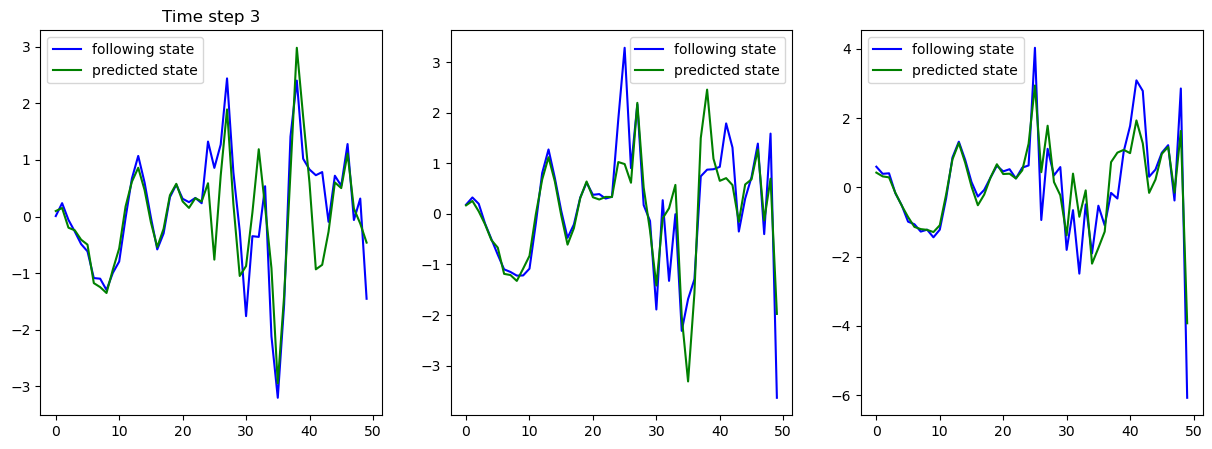

In [4]:
## Evaluate the predicition of the Koopman Dynamics
roll_out_sampler = roll_out(env, env_info)
num_trajactories=10
max_time_step=20
for i in range(1):
    test_buffer = roll_out_sampler.roll_out_sampler_with_env(num_trajactories=num_trajactories,
                                                             max_time_step=max_time_step, random_action=True)
    test_dataset = RLDataset(num_steps, state_dim, act_dim, 
                             state_hidden_dim=hidden_dim, 
                             act_hidden_dim=8, 
                             sample_traj_length=max_time_step, 
                             capacity=num_trajactories*(max_time_step-num_steps-1))
    test_dataset.obtain_data_from_obs_buffer(test_buffer)

j = np.random.randint(0, num_trajactories)
initial_states, actions, following_states, rewards, dones = test_dataset.__getitem__(j)

pred_next_states = []
for i in range(num_steps):
    state = initial_states[i].to(device).unsqueeze(0)
    action = actions[i].to(device).unsqueeze(0)
    
    next_state = Kdys_model(state, action).squeeze(0).detach().cpu().numpy()
    pred_next_states.append(next_state)

pred_next_states = np.array(pred_next_states)
print(pred_next_states.shape)
n_half_state_dim = state_dim 
fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].plot(following_states[1, :n_half_state_dim], c="b", label='following state')
axes[0].plot(pred_next_states[1, :n_half_state_dim], c="g", label='predicted state')
axes[0].set_title("Time step 1")
axes[0].legend()
axes[1].plot(following_states[2, :n_half_state_dim], c="b", label='following state')
axes[1].plot(pred_next_states[2, :n_half_state_dim], c="g", label='predicted state')
axes[0].set_title("Time step 2")
axes[1].legend()
axes[2].plot(following_states[3, :n_half_state_dim], c="b", label='following state')
axes[2].plot(pred_next_states[3, :n_half_state_dim], c="g", label='predicted state')
axes[0].set_title("Time step 3")
axes[2].legend()
plt.show()

In [5]:
value_net = Quad_Value_Net(hidden_dim).to(device)
value_net.load_state_dict(torch.load(save_path + '/Quad_Value_Net.pt', map_location=torch.device('cpu')))


solver = create_solver(env_info)()
policy = Policy(solver)

[INFO] Cretateing the Solver for wave


In [10]:
# Start Evaluation
eval_T = config["eval_T"]
eval_episodes = config["eval_episodes"]
eval_rewards = [[] for i in range(eval_episodes)]
eval_time = np.zeros(eval_episodes//10)
eval_traj = np.zeros((eval_episodes, eval_T+1, state_dim))
eval_traj_obs = np.zeros((eval_episodes, eval_T+1, state_dim))
eval_actions = np.zeros((eval_episodes, eval_T+1, act_dim))


for n in range(eval_episodes):
    
    test_init_state = env.state[:25] + np.random.normal(0, 0.01, 25)
    test_init_state = np.concatenate((test_init_state, np.zeros(25))) 

    env_test = gym.make(env_name, process_noise_cov=process_noise_cov, 
                        sensor_noise_cov=sensor_noise_cov,
                        n_state=n_state, n_observation=n_obs, n_action=n_action,
                        action_limit=action_limit, 
                        observation_limit=observation_limit,
                        Q_weight=Q_weight,
                        R_weight=R_weight)
    env_test.n_steps = config["eval_T"]
    start_time = time.time()
    t = 0
    state = env_test.reset()[0]
    eval_traj_obs[n, t, :] = state
    eval_traj[n, t, :] = env_test.state
    while t < eval_T:
        t += 1

        state = torch.tensor(state, dtype=torch.float32).to(device).unsqueeze(0)
        action = policy.select_actions(Kdys_model, value_net, state, if_batch=False).detach().cpu().numpy()

        eval_traj_obs[n, t, :] = state.detach().cpu().numpy()
        eval_actions[n, t, :] = action
        next_state, reward, done, _, _ = env_test.step(action)
        eval_rewards[n].append(reward)
        state = next_state
        
        eval_traj[n, t, :] = env_test.state
        
        if done:
            break
    end_time = time.time()
    if n%10 == 0:
        eval_time[n//10] = end_time-start_time 
    else: 
        eval_time[n//10] += end_time-start_time
    print("Test Episode:", n, " Reward:", np.sum(eval_rewards[n]), "Time:", end_time-start_time)

Test Episode: 0  Reward: -217.33537664872915 Time: 0.6219000816345215
Test Episode: 1  Reward: -166.93655646404045 Time: 0.6005020141601562
Test Episode: 2  Reward: -182.74341088960801 Time: 0.5951690673828125
Test Episode: 3  Reward: -169.70893547216963 Time: 0.6050980091094971
Test Episode: 4  Reward: -155.24662059586439 Time: 0.5841238498687744
Test Episode: 5  Reward: -140.9402485051419 Time: 0.565140962600708
Test Episode: 6  Reward: -128.12669980274615 Time: 0.5677790641784668
Test Episode: 7  Reward: -165.87755403614628 Time: 0.558121919631958
Test Episode: 8  Reward: -147.29919830829306 Time: 0.5974838733673096
Test Episode: 9  Reward: -183.12170275813327 Time: 0.609004020690918
Test Episode: 10  Reward: -159.01923751962585 Time: 0.5932748317718506
Test Episode: 11  Reward: -197.74130754280338 Time: 0.5702059268951416
Test Episode: 12  Reward: -203.6520551745807 Time: 0.591728925704956
Test Episode: 13  Reward: -234.7975435698405 Time: 0.6049108505249023
Test Episode: 14  Rewar

In [11]:
env_test.state_traj = eval_traj[0].T

eval_rewards = np.array(eval_rewards)
print("Mean Reward: ", np.mean(np.sum(eval_rewards, axis=1)))
print("Std Reward: ", np.std(np.sum(eval_rewards, axis=1)))
print("Mean Time: ", np.mean(eval_time))
print("Std Time: ", np.std(eval_time))

save_eval_path = "eval_results"
if not os.path.exists(save_eval_path):
    os.makedirs(save_eval_path)
save_eval_path = save_eval_path + "/" + "{}".format(env_name)
if not os.path.exists(save_eval_path):
    os.makedirs(save_eval_path)
    
np.save(save_eval_path + "/" + "eval_traj.npy", eval_traj)
np.save(save_eval_path + "/" + "eval_actions.npy", eval_actions)
np.save(save_eval_path + "/" + "eval_rewards.npy", eval_rewards)

Mean Reward:  -167.16600243665164
Std Reward:  25.504534255240483
Mean Time:  5.7965278148651125
Std Time:  0.24029058114557642


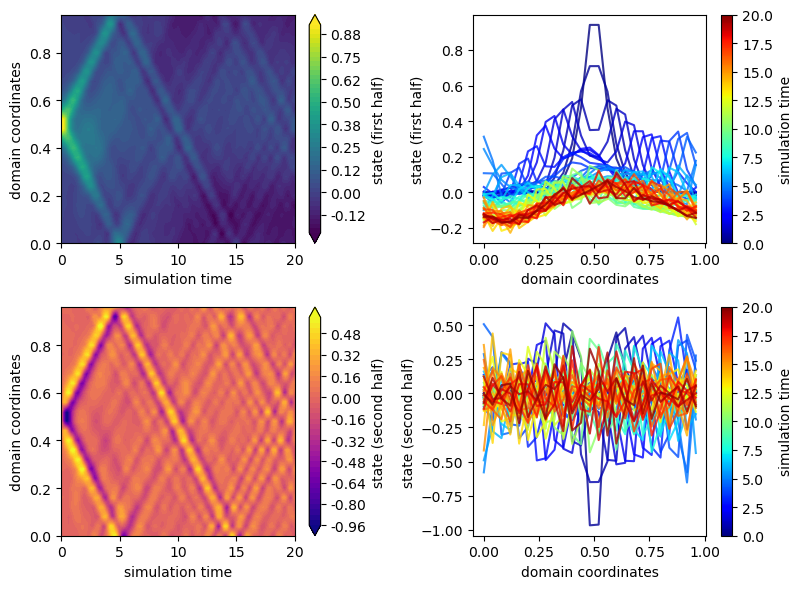

In [12]:
_plot_coupled_pde(env_test, save_eval_path, display=True, surface3d=False)

### Using MPC

In [13]:
from Koopman_QP import Koopman_MPC_QP

In [14]:
eval_rewards_qp = np.zeros(eval_episodes)
eval_time_qp = np.zeros(eval_episodes//10)
for i in range(eval_episodes):
    env_test = gym.make(env_name, process_noise_cov=process_noise_cov, 
                    sensor_noise_cov=sensor_noise_cov,
                    n_state=n_state, n_observation=n_obs, n_action=n_action,
                    action_limit=action_limit, 
                    observation_limit=observation_limit,
                    Q_weight=Q_weight,
                    R_weight=R_weight)
    env_test.n_steps = config["eval_T"]
    mpc_controllor = Koopman_MPC_QP(env, Kdys_model)
    
    start_time = time.time()
    reward, state_traj, action_traj = mpc_controllor.perform_MPC(H=env.n_steps-1)
    end_time = time.time()
    
    eval_rewards_qp[i] = np.sum(reward)
    if n%10 == 0:
        eval_time_qp[n//10] = end_time-start_time 
    else: 
        eval_time_qp[n//10] += end_time-start_time

    print("Test Episode:", i, " Reward:", eval_rewards_qp[i], "Time:", end_time-start_time)



Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 67.08it/s]


Test Episode: 0  Reward: -543.9289932099756 Time: 2.9691169261932373


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.31it/s]


Test Episode: 1  Reward: -376.1311138704152 Time: 2.914357900619507


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.90it/s]


Test Episode: 2  Reward: -518.8171779421316 Time: 2.8896358013153076


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.38it/s]


Test Episode: 3  Reward: -538.8034889954846 Time: 2.9113879203796387


Performing Koopman MPC: 100%|██████████| 199/199 [00:03<00:00, 63.37it/s]


Test Episode: 4  Reward: -517.4271853169934 Time: 3.1417500972747803


Performing Koopman MPC: 100%|██████████| 199/199 [00:03<00:00, 66.14it/s]


Test Episode: 5  Reward: -441.9476779394531 Time: 3.0100836753845215


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.20it/s]


Test Episode: 6  Reward: -447.3500486886142 Time: 2.9191198348999023


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 66.76it/s]


Test Episode: 7  Reward: -407.59811034878084 Time: 2.9820542335510254


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 67.33it/s]


Test Episode: 8  Reward: -403.7002579286389 Time: 2.957149028778076


Performing Koopman MPC: 100%|██████████| 199/199 [00:03<00:00, 65.82it/s]


Test Episode: 9  Reward: -458.03412738353995 Time: 3.025067090988159


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 66.47it/s]


Test Episode: 10  Reward: -372.93327666444895 Time: 2.9958839416503906


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 67.27it/s]


Test Episode: 11  Reward: -404.1189240764516 Time: 2.9595861434936523


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 69.62it/s]


Test Episode: 12  Reward: -505.52095840202463 Time: 2.8595101833343506


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 66.62it/s]


Test Episode: 13  Reward: -409.08992440493193 Time: 2.9883179664611816


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.67it/s]


Test Episode: 14  Reward: -468.7948797736589 Time: 2.898822784423828


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 67.81it/s]


Test Episode: 15  Reward: -484.8921342215086 Time: 2.935626983642578


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 66.89it/s]


Test Episode: 16  Reward: -489.42648786902123 Time: 2.97613525390625


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 66.85it/s]


Test Episode: 17  Reward: -444.7399003263014 Time: 2.97832989692688


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 67.83it/s]


Test Episode: 18  Reward: -387.4408256238508 Time: 2.9353690147399902


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.11it/s]


Test Episode: 19  Reward: -427.78372907982157 Time: 2.9228830337524414


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 66.48it/s]


Test Episode: 20  Reward: -463.1874369098904 Time: 2.9945740699768066


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 66.70it/s]


Test Episode: 21  Reward: -436.9271660539548 Time: 2.9848639965057373


Performing Koopman MPC: 100%|██████████| 199/199 [00:03<00:00, 65.95it/s]


Test Episode: 22  Reward: -440.24755136143773 Time: 3.0183398723602295


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 67.58it/s]


Test Episode: 23  Reward: -405.7760270068098 Time: 2.945817708969116


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.18it/s]


Test Episode: 24  Reward: -422.75180032037844 Time: 2.9200220108032227


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.59it/s]


Test Episode: 25  Reward: -397.78062814985316 Time: 2.9025516510009766


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 66.68it/s]


Test Episode: 26  Reward: -485.422225224778 Time: 2.9855828285217285


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 67.67it/s]


Test Episode: 27  Reward: -365.51597861276355 Time: 2.941713809967041


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 67.54it/s]


Test Episode: 28  Reward: -528.6998252963308 Time: 2.947404146194458


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.37it/s]


Test Episode: 29  Reward: -388.3935264585116 Time: 2.9116392135620117


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.63it/s]


Test Episode: 30  Reward: -437.34632161532875 Time: 2.900905132293701


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.60it/s]


Test Episode: 31  Reward: -403.99369008492727 Time: 2.902191162109375


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 66.38it/s]


Test Episode: 32  Reward: -445.5951519172186 Time: 2.9991841316223145


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.60it/s]


Test Episode: 33  Reward: -539.1848609096553 Time: 2.901824951171875


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.83it/s]


Test Episode: 34  Reward: -401.28206808623986 Time: 2.892204761505127


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 67.23it/s]


Test Episode: 35  Reward: -538.3638457274044 Time: 2.9616448879241943


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.08it/s]


Test Episode: 36  Reward: -531.6869309970315 Time: 2.924377202987671


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.26it/s]


Test Episode: 37  Reward: -560.6524181137738 Time: 2.9163527488708496


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.63it/s]


Test Episode: 38  Reward: -535.8398801921117 Time: 2.9005918502807617


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.63it/s]


Test Episode: 39  Reward: -380.08821982282416 Time: 2.9005911350250244


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 69.24it/s]


Test Episode: 40  Reward: -381.98990447702846 Time: 2.8752760887145996


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 66.83it/s]


Test Episode: 41  Reward: -365.5527825722305 Time: 2.9790217876434326


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.94it/s]


Test Episode: 42  Reward: -492.916492690161 Time: 2.8881301879882812


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 69.44it/s]


Test Episode: 43  Reward: -392.11167849724393 Time: 2.867138147354126


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.48it/s]


Test Episode: 44  Reward: -472.7855402498434 Time: 2.9069318771362305


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 66.64it/s]


Test Episode: 45  Reward: -509.2914715574901 Time: 2.987612724304199


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.91it/s]


Test Episode: 46  Reward: -481.8931692091603 Time: 2.8890419006347656


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.16it/s]


Test Episode: 47  Reward: -397.5525053916676 Time: 2.9209349155426025


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 67.18it/s]


Test Episode: 48  Reward: -494.9396805650783 Time: 2.9636409282684326


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 67.27it/s]


Test Episode: 49  Reward: -407.7682883990532 Time: 2.959470272064209


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 67.94it/s]


Test Episode: 50  Reward: -442.8601691672184 Time: 2.9305951595306396


Performing Koopman MPC: 100%|██████████| 199/199 [00:03<00:00, 62.89it/s]


Test Episode: 51  Reward: -429.4518307810157 Time: 3.1655988693237305


Performing Koopman MPC: 100%|██████████| 199/199 [00:03<00:00, 66.33it/s]


Test Episode: 52  Reward: -415.03628835439054 Time: 3.001518964767456


Performing Koopman MPC: 100%|██████████| 199/199 [00:03<00:00, 59.84it/s]


Test Episode: 53  Reward: -542.0939358595458 Time: 3.3269729614257812


Performing Koopman MPC: 100%|██████████| 199/199 [00:03<00:00, 55.65it/s]


Test Episode: 54  Reward: -366.77638131397964 Time: 3.576828956604004


Performing Koopman MPC: 100%|██████████| 199/199 [00:03<00:00, 61.65it/s]


Test Episode: 55  Reward: -533.7449826217025 Time: 3.229731798171997


Performing Koopman MPC: 100%|██████████| 199/199 [00:03<00:00, 64.98it/s]


Test Episode: 56  Reward: -390.95466360481157 Time: 3.0636138916015625


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.06it/s]


Test Episode: 57  Reward: -516.49192002614 Time: 2.9251599311828613


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 67.43it/s]


Test Episode: 58  Reward: -536.0020905052504 Time: 2.9523749351501465


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 69.12it/s]


Test Episode: 59  Reward: -497.84198594717657 Time: 2.8804562091827393


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 67.27it/s]


Test Episode: 60  Reward: -511.1230411204095 Time: 2.9592089653015137


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.65it/s]


Test Episode: 61  Reward: -426.3074647417324 Time: 2.900024890899658


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 67.19it/s]


Test Episode: 62  Reward: -391.3454536770357 Time: 2.963013172149658


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 66.36it/s]


Test Episode: 63  Reward: -403.70140972196646 Time: 2.999730348587036


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 67.26it/s]


Test Episode: 64  Reward: -476.31743120114874 Time: 2.9602391719818115


Performing Koopman MPC: 100%|██████████| 199/199 [00:03<00:00, 66.29it/s]


Test Episode: 65  Reward: -418.4250486412466 Time: 3.003383159637451


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 66.76it/s]


Test Episode: 66  Reward: -517.8941799278018 Time: 2.98193097114563


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 66.74it/s]


Test Episode: 67  Reward: -401.010960159842 Time: 2.9833719730377197


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 67.99it/s]


Test Episode: 68  Reward: -461.3399826000064 Time: 2.92791485786438


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.25it/s]


Test Episode: 69  Reward: -487.7061832899553 Time: 2.9170467853546143


Performing Koopman MPC: 100%|██████████| 199/199 [00:03<00:00, 65.68it/s]


Test Episode: 70  Reward: -380.5601521474292 Time: 3.031109094619751


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.41it/s]


Test Episode: 71  Reward: -419.93059836738837 Time: 2.9102210998535156


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 67.72it/s]


Test Episode: 72  Reward: -536.2563043988074 Time: 2.9397428035736084


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 66.65it/s]


Test Episode: 73  Reward: -572.9522151490836 Time: 2.9871859550476074


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 67.39it/s]


Test Episode: 74  Reward: -452.9843169263673 Time: 2.954580068588257


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 66.54it/s]


Test Episode: 75  Reward: -408.2988337509787 Time: 2.9923198223114014


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.01it/s]


Test Episode: 76  Reward: -417.4201581620107 Time: 2.927567958831787


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.16it/s]


Test Episode: 77  Reward: -383.5904775981843 Time: 2.920896053314209


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 67.98it/s]


Test Episode: 78  Reward: -488.8720339869885 Time: 2.9288949966430664


Performing Koopman MPC: 100%|██████████| 199/199 [00:03<00:00, 66.15it/s]


Test Episode: 79  Reward: -462.71615734558134 Time: 3.009347915649414


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 66.35it/s]


Test Episode: 80  Reward: -490.6735385870767 Time: 3.000202178955078


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 66.80it/s]


Test Episode: 81  Reward: -380.05393203718654 Time: 2.9808878898620605


Performing Koopman MPC: 100%|██████████| 199/199 [00:03<00:00, 65.96it/s]


Test Episode: 82  Reward: -513.52996094682 Time: 3.0177810192108154


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.53it/s]


Test Episode: 83  Reward: -495.76005173686144 Time: 2.9048659801483154


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 67.07it/s]


Test Episode: 84  Reward: -480.17456845917167 Time: 2.968250036239624


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 66.39it/s]


Test Episode: 85  Reward: -425.0719930519231 Time: 2.9988019466400146


Performing Koopman MPC: 100%|██████████| 199/199 [00:03<00:00, 63.83it/s]


Test Episode: 86  Reward: -474.74712156110695 Time: 3.1187610626220703


Performing Koopman MPC: 100%|██████████| 199/199 [00:03<00:00, 65.22it/s]


Test Episode: 87  Reward: -368.93727746382774 Time: 3.052550792694092


Performing Koopman MPC: 100%|██████████| 199/199 [00:03<00:00, 65.19it/s]


Test Episode: 88  Reward: -384.30354991055054 Time: 3.053719997406006


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 67.97it/s]


Test Episode: 89  Reward: -504.56195947758164 Time: 2.9292211532592773


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 69.01it/s]


Test Episode: 90  Reward: -573.3724319154526 Time: 2.884685754776001


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 67.04it/s]


Test Episode: 91  Reward: -469.0202305156613 Time: 2.9693241119384766


Performing Koopman MPC: 100%|██████████| 199/199 [00:03<00:00, 65.11it/s]


Test Episode: 92  Reward: -463.7617967486761 Time: 3.0578360557556152


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 67.77it/s]


Test Episode: 93  Reward: -469.9047091237459 Time: 2.937685012817383


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.94it/s]


Test Episode: 94  Reward: -440.7867657107756 Time: 2.887850284576416


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.66it/s]


Test Episode: 95  Reward: -512.0960599140478 Time: 2.8999269008636475


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.90it/s]


Test Episode: 96  Reward: -413.1062586964566 Time: 2.8898868560791016


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.94it/s]


Test Episode: 97  Reward: -387.3513839452387 Time: 2.8876841068267822


Performing Koopman MPC: 100%|██████████| 199/199 [00:03<00:00, 66.27it/s]


Test Episode: 98  Reward: -440.8421332935461 Time: 3.0038158893585205


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 66.89it/s]

Test Episode: 99  Reward: -365.2299086433569 Time: 2.9764649868011475


In [15]:
print("Mean Reward Koopman MPC QP: ", np.mean(eval_rewards_qp))
print("Std Reward Koopman MPC QP: ", np.std(eval_rewards_qp))
print("Mean Time Koopman MPC QP: ", np.mean(eval_time_qp))
print("Std Time Koopman MPC QP: ", np.std(eval_time_qp))

Mean Reward Koopman MPC QP:  -452.9730857137048
Std Reward Koopman MPC QP:  56.54856368331051
Mean Time Koopman MPC QP:  29.683054757118224
Std Time Koopman MPC QP:  89.04916427135468
